In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp
import math


### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

-0.01084098704 0.02815552265 0.00039265133851975654
-2.7060759968018644 5.4425630702179895 -1.848446242872269e-17


Text(0.5, 1.0, 'Original matrix')

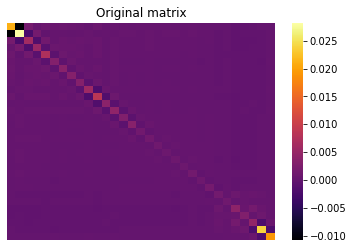

In [2]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)
scaler_sys = StandardScaler()
scaler_sys.fit(syscov)
syscov = scaler_sys.transform(syscov)
print(np.min(syscov), np.max(syscov), np.mean(syscov))
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(syscov)), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix')

In [3]:
def permutMatrix(omatrix, nmatrix):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        p = P@omatrix@P.T
        p = symmetrical(p)
        matrixset[it, :, :] = p
    return matrixset


In [4]:
def symmetrical(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix)):
    #         if np.iscomplex(syscov[i,j]):
    #             print("COMPLEX")
            if matrix[i,j] > matrix[j,i]:
    #             print(i,j)
    #             print(syscov[i,j], syscov[j,i]) 
    #             count+=1
                matrix[i, j] = matrix[j, i]
            elif matrix[i,j] < matrix[j,i]:
                matrix[j, i] = matrix[i, j]
    return matrix

In [5]:

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix            

### Generate a data set with covariance matrix from the original plus gaussian noise

In [6]:
magnitudes = matrixMag(syscov)

In [7]:
numMatrix = 2000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))
permMatrix = permutMatrix(syscov, numMatrix)
print(np.shape(permMatrix))

(2000, 31, 31)


Text(0.5, 1.0, 'PERMUTATED MATRIX')

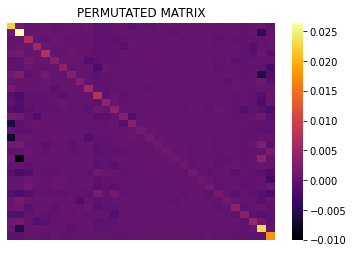

In [8]:
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(permMatrix[100])), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
# sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(permMatrix[0, :, :])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("PERMUTATED MATRIX")

In [9]:
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    for row in range(nsize):
        for col in range(nsize):
            if row == col:
                err = np.random.rand()
                covset[i, row, col] = permMatrix[i, row, col] + 1e-4*err*magnitudes[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col] + 1e-4*err*magnitudes[row, col]
            else:
                covset[i, row, col] = permMatrix[i, row, col] + 0.1*np.random.rand()*magnitudes[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col]  + np.random.rand()*magnitudes[row, col]

 Generating 2000 matrix  

In [10]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

(2000, 31, 31)


Text(0.5, 1.0, 'NOISE MATRIX')

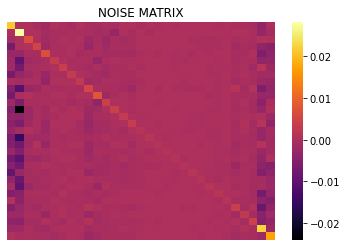

In [11]:
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_noise_test[0])), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
# sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(permMatrix[0, :, :])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("NOISE MATRIX")

Text(0.5, 1.0, 'TEST MATRIX')

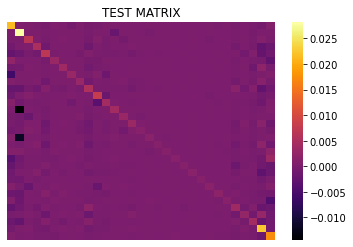

In [12]:
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_test[0])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")

In [13]:
input_img = tf.keras.Input(shape=(31, 31, 1))

x = layers.ZeroPadding2D(((5,4),(5,4)))(input_img)
x = layers.Conv2D(2, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(2, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (5, 5), activation='linear', padding='same')(x)
decoded = layers.Cropping2D(cropping=((5, 4), (5, 4)))(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 31, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 2)         52        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 2)         38        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 2)         38    

In [14]:
autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=500,
                batch_size=128,
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))

Epoch 1/500
13/13 [==============================] - 1s 68ms/step - loss: 1.0761 - val_loss: 1.0608
Epoch 2/500
13/13 [==============================] - 1s 50ms/step - loss: 1.0574 - val_loss: 1.0498
Epoch 3/500
13/13 [==============================] - 1s 49ms/step - loss: 1.0482 - val_loss: 1.0435
Epoch 4/500
13/13 [==============================] - 1s 51ms/step - loss: 1.0411 - val_loss: 1.0341
Epoch 5/500
13/13 [==============================] - 1s 50ms/step - loss: 1.0314 - val_loss: 1.0256
Epoch 6/500
13/13 [==============================] - 1s 50ms/step - loss: 1.0234 - val_loss: 1.0195
Epoch 7/500
13/13 [==============================] - 1s 51ms/step - loss: 1.0178 - val_loss: 1.0136
Epoch 8/500
13/13 [==============================] - 1s 51ms/step - loss: 1.0116 - val_loss: 1.0064
Epoch 9/500
13/13 [==============================] - 1s 50ms/step - loss: 1.0041 - val_loss: 0.9977
Epoch 10/500
13/13 [==============================] - 1s 50ms/step - loss: 0.9954 - val_loss: 0.9879

13/13 [==============================] - 1s 50ms/step - loss: 0.2444 - val_loss: 0.2447
Epoch 83/500
13/13 [==============================] - 1s 49ms/step - loss: 0.2441 - val_loss: 0.2443
Epoch 84/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2436 - val_loss: 0.2441
Epoch 85/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2437 - val_loss: 0.2438
Epoch 86/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2436 - val_loss: 0.2435
Epoch 87/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2430 - val_loss: 0.2432
Epoch 88/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2429 - val_loss: 0.2431
Epoch 89/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2428 - val_loss: 0.2426
Epoch 90/500
13/13 [==============================] - 1s 51ms/step - loss: 0.2423 - val_loss: 0.2423
Epoch 91/500
13/13 [==============================] - 1s 51ms/step - loss: 0.2419 - val_loss: 0.2423
Epo

13/13 [==============================] - 1s 51ms/step - loss: 0.2223 - val_loss: 0.2220
Epoch 163/500
13/13 [==============================] - 1s 49ms/step - loss: 0.2220 - val_loss: 0.2264
Epoch 164/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2235 - val_loss: 0.2224
Epoch 165/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2221 - val_loss: 0.2221
Epoch 166/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2220 - val_loss: 0.2220
Epoch 167/500
13/13 [==============================] - 1s 49ms/step - loss: 0.2219 - val_loss: 0.2221
Epoch 168/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2219 - val_loss: 0.2218
Epoch 169/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2218 - val_loss: 0.2217
Epoch 170/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2215 - val_loss: 0.2221
Epoch 171/500
13/13 [==============================] - 1s 50ms/step - loss: 0.2218 - val_loss: 0

13/13 [==============================] - 1s 57ms/step - loss: 0.2181 - val_loss: 0.2183
Epoch 243/500
13/13 [==============================] - 1s 55ms/step - loss: 0.2178 - val_loss: 0.2181
Epoch 244/500
13/13 [==============================] - 1s 52ms/step - loss: 0.2176 - val_loss: 0.2177
Epoch 245/500
13/13 [==============================] - 1s 56ms/step - loss: 0.2178 - val_loss: 0.2188
Epoch 246/500
13/13 [==============================] - 1s 54ms/step - loss: 0.2181 - val_loss: 0.2186
Epoch 247/500
13/13 [==============================] - 1s 60ms/step - loss: 0.2183 - val_loss: 0.2178
Epoch 248/500
13/13 [==============================] - 1s 60ms/step - loss: 0.2176 - val_loss: 0.2176
Epoch 249/500
13/13 [==============================] - 1s 60ms/step - loss: 0.2175 - val_loss: 0.2180
Epoch 250/500
13/13 [==============================] - 1s 68ms/step - loss: 0.2175 - val_loss: 0.2176
Epoch 251/500
13/13 [==============================] - 1s 66ms/step - loss: 0.2175 - val_loss: 0

13/13 [==============================] - 1s 60ms/step - loss: 0.2160 - val_loss: 0.2160
Epoch 323/500
13/13 [==============================] - 1s 58ms/step - loss: 0.2152 - val_loss: 0.2153
Epoch 324/500
13/13 [==============================] - 1s 62ms/step - loss: 0.2150 - val_loss: 0.2159
Epoch 325/500
13/13 [==============================] - 1s 60ms/step - loss: 0.2155 - val_loss: 0.2155
Epoch 326/500
13/13 [==============================] - 1s 59ms/step - loss: 0.2152 - val_loss: 0.2160
Epoch 327/500
13/13 [==============================] - 1s 60ms/step - loss: 0.2155 - val_loss: 0.2151
Epoch 328/500
13/13 [==============================] - 1s 55ms/step - loss: 0.2154 - val_loss: 0.2153
Epoch 329/500
13/13 [==============================] - 1s 57ms/step - loss: 0.2150 - val_loss: 0.2150
Epoch 330/500
13/13 [==============================] - 1s 58ms/step - loss: 0.2159 - val_loss: 0.2163
Epoch 331/500
13/13 [==============================] - 1s 55ms/step - loss: 0.2156 - val_loss: 0

13/13 [==============================] - 1s 53ms/step - loss: 0.2140 - val_loss: 0.2139
Epoch 403/500
13/13 [==============================] - 1s 54ms/step - loss: 0.2138 - val_loss: 0.2145
Epoch 404/500
13/13 [==============================] - 1s 57ms/step - loss: 0.2137 - val_loss: 0.2136
Epoch 405/500
13/13 [==============================] - 1s 54ms/step - loss: 0.2134 - val_loss: 0.2136
Epoch 406/500
13/13 [==============================] - 1s 54ms/step - loss: 0.2137 - val_loss: 0.2137
Epoch 407/500
13/13 [==============================] - 1s 57ms/step - loss: 0.2143 - val_loss: 0.2143
Epoch 408/500
13/13 [==============================] - 1s 53ms/step - loss: 0.2137 - val_loss: 0.2133
Epoch 409/500
13/13 [==============================] - 1s 56ms/step - loss: 0.2133 - val_loss: 0.2139
Epoch 410/500
13/13 [==============================] - 1s 57ms/step - loss: 0.2135 - val_loss: 0.2134
Epoch 411/500
13/13 [==============================] - 1s 54ms/step - loss: 0.2140 - val_loss: 0

13/13 [==============================] - 1s 65ms/step - loss: 0.2133 - val_loss: 0.2125
Epoch 483/500
13/13 [==============================] - 1s 59ms/step - loss: 0.2128 - val_loss: 0.2124
Epoch 484/500
13/13 [==============================] - 1s 61ms/step - loss: 0.2123 - val_loss: 0.2140
Epoch 485/500
13/13 [==============================] - 1s 60ms/step - loss: 0.2136 - val_loss: 0.2126
Epoch 486/500
13/13 [==============================] - 1s 62ms/step - loss: 0.2128 - val_loss: 0.2124
Epoch 487/500
13/13 [==============================] - 1s 61ms/step - loss: 0.2122 - val_loss: 0.2124
Epoch 488/500
13/13 [==============================] - 1s 63ms/step - loss: 0.2124 - val_loss: 0.2126
Epoch 489/500
13/13 [==============================] - 1s 67ms/step - loss: 0.2126 - val_loss: 0.2124
Epoch 490/500
13/13 [==============================] - 1s 62ms/step - loss: 0.2124 - val_loss: 0.2151
Epoch 491/500
13/13 [==============================] - 1s 67ms/step - loss: 0.2144 - val_loss: 0

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

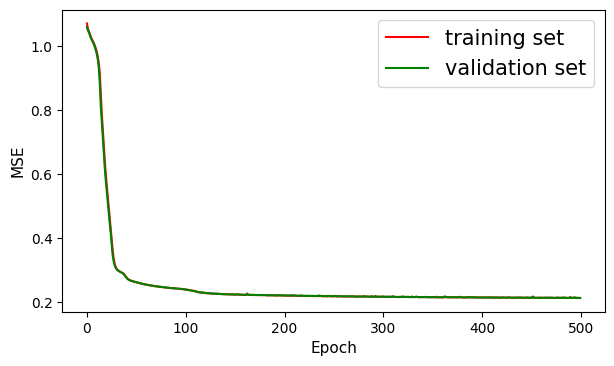

In [15]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [16]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

0.21228741109371183 0.21220636367797852


In [17]:
file2 = '/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

Text(0.5, 1.0, 'Test noise matrix')

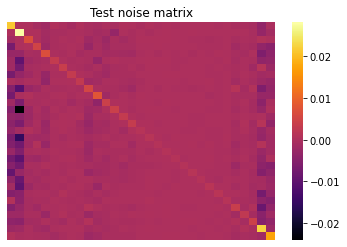

In [18]:
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_noise_test[0])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Test noise matrix')

(400, 31, 31)


Text(0.5, 1.0, 'Clean matrix')

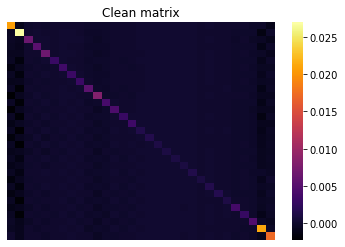

In [19]:
clean_img = autoencoder.predict(covset_noise_test)

print(np.shape(covset_noise_test))
clean_imgr = scaler_sys.inverse_transform(clean_img[0].reshape(31,31))

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Clean matrix')

# np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")

Text(0.5, 1.0, 'Clean matrix 2')

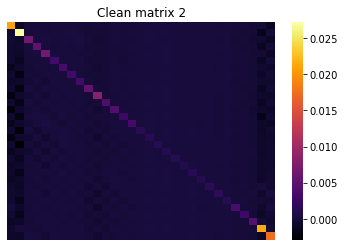

In [20]:
clean_img = autoencoder.predict(clean_img)

clean_imgr = scaler_sys.inverse_transform(clean_img[0].reshape(31,31))

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('Clean matrix 2')

Text(0.5, 1.0, 'Filled matrix')

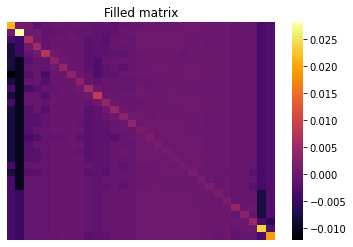

In [21]:
filled_matrix = np.zeros((nsize, nsize))
# err = np.random.randn()
for row in range(nsize):
    for col in range(nsize):
        if row == col:
#             err = np.random.randn()
            filled_matrix[row, col] = syscov[row, col] 
#     + 0.1*err*magnitudes[row, col]
        else:
            filled_matrix[row, col] = magnitudes[row, col] # this work with original syscov
#             filled_matrix[row, col] = 0.5*np.random.rand()

sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(filled_matrix)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Filled matrix')
# np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat",scaler_sys.inverse_transform(filled_matrix).reshape(31,31), delimiter= " ", header="#fake COV")

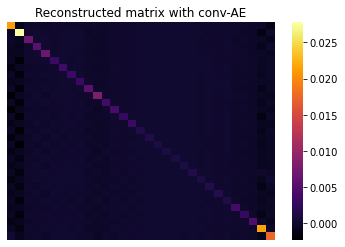

In [22]:
# filled_matrix = scaler_sys.transform(filled_matrix).reshape(1,31,31,1)

clean_img = autoencoder.predict(filled_matrix.reshape(1,31,31,1))

clean_imgr = scaler_sys.inverse_transform(clean_img[0,:,:,0])

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('Reconstructed matrix with conv-AE')
plt.savefig('rec_matrix_conv_ae.png')

In [25]:
np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_imgr.reshape(31,31), delimiter= " ", header="#fake COV")

In [26]:
autoencoder.save('../models/autoencoderCONV_JLA.h5')
# decoder.save('../models/decoderJLA.h5')
# encoder.save('../models/encoderJLA.h5')